In [ ]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
import torch
import torch.nn as nn
import os


from sklearn.preprocessing import MinMaxScaler


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


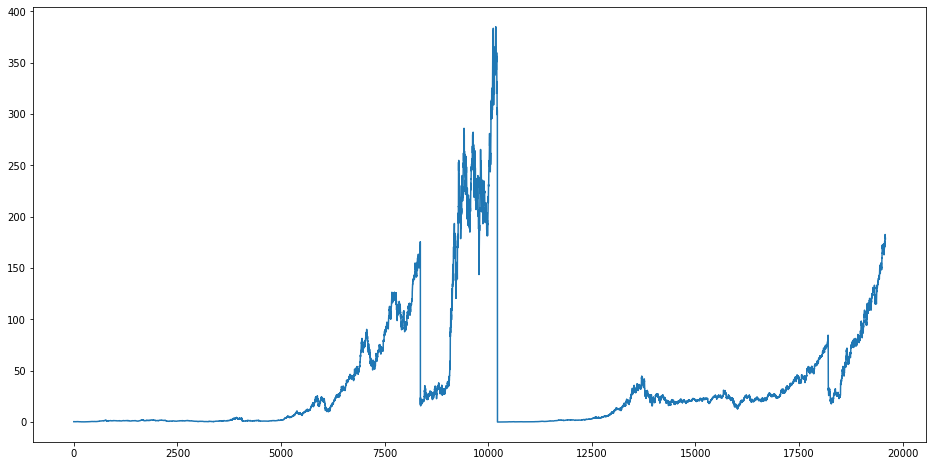

In [ ]:
file_path = "gdrive/MyDrive/Scalping/stock_data.csv"
#Colab에서 실행할 것
#데이터와 코드는 같은 경로에 위치할 필요는 없지만
#현재 드라이브에서의 상대경로를 알고 있어야함(gdrive/MyDrive/파일이_있는_상대_경로)
df=pd.read_csv(file_path)
df.head()

#예시 데이터가 4가지 종류의 기업 데이터이기 때문에 한 기업 aapl의 데이터만 셀렉
apple_df = df[df.Stock=="AAPL"]
apple_df["Date"]=pd.to_datetime(apple_df.Date,format="%Y-%m-%d")
apple_df.index=apple_df['Date']


plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

In [ ]:
class BahdanauAttention(nn.Module) : 
  def __init__(self, units) : 
    super(BahdanauAttention, self).__init__()
    self.flatter = nn.Flatten()
    self.W1 = nn.Linear(128, units)
    self.W2 = nn.Linear(128, units)
    self.V = nn.Linear(units, 1)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, values, query): # 단, 바다나우에서 key와 value는 같음
    # values shape == (bacth_size, time_step, decoder_hidden_size)
    # query shape == (batch_size, decoder_hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, decoder hidden size)
    # score 계산을 위해 뒤에서 할 덧셈을 위해서 차원을 변경
    hidden_with_time_axis = query.unsqueeze(1)

    # score shape == (batch_size, max_length(max time step), 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length(max time step), units)
    score = self.V(torch.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length(max time step), 1)
    attention_weights = self.softmax(score)

    # context_vector shape after sum == (batch_size, hidden_size)
    # attention_weights
    context_vector = attention_weights * values
    context_vector = torch.sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
#장 종료 값만 추출, 다른 feature(시작가, 평균가 등)을 사용할 경우 하단의 close를 수정하면됨
data=apple_df.sort_index(ascending=True,axis=0)
#new_dataset=pd.DataFrame(index=range(0,len(apple_df)),columns=['Open', 'Close', 'High', 'Low', 'Volume'])
new_dataset=pd.DataFrame(index=range(0,len(apple_df)),columns=['Close'])

for i in range(0,len(data)):
    # new_dataset["Date"][i]=data['Date'][i]
    #new_dataset["Open"][i]=data["Open"][i]
    new_dataset["Close"][i]=data["Close"][i]
    #new_dataset["High"][i]=data["High"][i]
    #new_dataset["Low"][i]=data["Low"][i]
    #new_dataset["Volume"][i]=data["Volume"][i]
  
print(new_dataset.shape)
type(new_dataset)

(8364, 1)


pandas.core.frame.DataFrame

In [ ]:
scaler0=MinMaxScaler(feature_range=(0,1))
scaler1=MinMaxScaler(feature_range=(0,1))
scaler2=MinMaxScaler(feature_range=(0,1))
scaler3=MinMaxScaler(feature_range=(0,1))
scaler4=MinMaxScaler(feature_range=(0,1))

#final_open = new_dataset["Open"]
final_close = new_dataset["Close"]
#final_high = new_dataset["High"]
#final_low = new_dataset["Low"]
#final_vol = new_dataset["Volume"]

#final_open = (final_open.values).reshape(-1, 1)
final_close = (final_close.values).reshape(-1, 1)
#final_high = (final_high.values).reshape(-1, 1)
#final_low = (final_low.values).reshape(-1, 1) 
#final_vol = (final_vol.values).reshape(-1, 1) 

print(type(final_close))

#scaled_open_data=scaler0.fit_transform(final_open)
scaled_close_data=scaler1.fit_transform(final_close)
#scaled_high_data=scaler2.fit_transform(final_high)
#scaled_low_data=scaler3.fit_transform(final_low)
#scaled_vol_data=scaler4.fit_transform(final_vol)

print(type(scaled_close_data))
print(scaled_close_data)
print(scaled_close_data.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[[0.00110258]
 [0.0010881 ]
 [0.00113189]
 ...
 [1.        ]
 [0.99794731]
 [0.99464019]]
(8364, 1)


In [ ]:
#final_dataset=np.concatenate((scaled_open_data, scaled_close_data, scaled_high_data, scaled_low_data, scaled_vol_data), axis=1)
final_dataset=np.concatenate(scaled_close_data)
final_dataset = np.expand_dims(final_dataset, axis=1)
print(final_dataset.shape)
print(final_dataset[0])

#트레이닝 데이터 분할(향후 커스텀 데이터 사용시 커스텀 데이터의 길이에 맞는 인덱스 수정)
#train_data=final_dataset[0:8000,:]
#valid_data=final_dataset[8000:,:]
train_data=final_dataset[0:8000]
valid_data=final_dataset[8000:]

x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    #x_train_data.append(final_dataset[i-60:i, :])
    #y_train_data.append(final_dataset[i,1]) # close를 target으로
    x_train_data.append(final_dataset[i-60:i])
    y_train_data.append(final_dataset[i]) # close를 target으로
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
#x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

(8364, 1)
[0.00110258]


In [ ]:
print(x_train_data.shape)
print(y_train_data.shape)
print(type(x_train_data))
print(type(y_train_data))

(7940, 60, 1)
(7940, 1)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
class StockDataset(torch.utils.data.Dataset) : 
  def __init__(self, X, Y) : 
    self.input_data = torch.from_numpy(X).float()
    self.target_data = torch.from_numpy(Y).float()
  
  def __len__(self) :
    return len(self.input_data)

  def __getitem__(self, idx) :
    if torch.is_tensor(idx) :
      idx = idx.tolist()

    x = self.input_data[idx]
    y = self.target_data[idx]
    return x, y
    

In [ ]:
train_dataset = StockDataset(x_train_data, y_train_data)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True)

In [ ]:
def save(attention, final_output, target_lable) : 
    # 여기서 저장할 데이터는 attention과 최종 output
    # 논문에서는 decoder의 time_step별 output과 time_step별 최종 output을 CEM의 데이터로 이용한다
    # 여기서는 decoder가 따로 있지 않으므로 attention과 최종 output만을 저장한다
    # 데이터 형태는 (batch_size, attention (60), output (1), target (1))
    save_path = "gdrive/MyDrive/Scalping/Data/" + "CEM_data.p"
    #attentions = []
    #outputs = []
    #for i in range(attention.shape[0]) : 
    #  attentions.append(attention[i].item())
    #  outputs.append(final_output.item())
    with open(save_path, "wb") as p :
      pickle.dump((attention, final_output, target_lable), p)

In [ ]:
time_step = 60
#latent_dim = 5
latent_dim = 1

import torch.nn.functional as F

sequence_input = torch.Tensor(time_step, 8, latent_dim)
lstm, (state_h, state_c) = nn.LSTM(input_size = latent_dim, hidden_size = 64, num_layers=2, dropout=0.5, bidirectional=True)(sequence_input)
print(lstm.shape, state_h.shape, state_c.shape)
state_h = torch.cat((state_h[2], state_h[3]), 1)
state_c = torch.cat((state_c[2], state_c[3]), 1)
print(state_h.shape)

lstm = lstm.permute(1, 0, 2)
attention = BahdanauAttention(64)
context_vector, attention_weights = attention(lstm, state_h)
print(context_vector.shape, "context vector")
print(attention_weights.shape, "attention_weiths")

class model(nn.Module) :
  def __init__(self) :
    super(model, self).__init__()
    self.lstm = nn.LSTM(input_size = latent_dim, hidden_size = 64, num_layers=2, dropout=0.5, bidirectional=True)
    self.attention = BahdanauAttention(64)
    self.dense1 = nn.Linear(128, 20)
    self.dropout = nn.Dropout(0.5)
    self.o = nn.Linear(20, 1)
    self.iter = 0

  def forward(self, inputs) :
    # inputs은 (batch_size, sequence_length, latent_dim)
    # 이걸 (sequence_length, batch_size, latent_dim) 으로 바꿔야 한다
    inputs = inputs.permute(1, 0, 2)
    lstm, (state_h, state_c) = self.lstm(inputs)

    # lstm : (sequence length, batch size, 2(bi)*64)
    # state_h : (2(bi)*2(layer num), batch_size, 64)
    # state_c : (2(bi)*2(layer num), batch_size, 64)
    # => 이 중 2번째 layer(마지막) 것만 추출하고 forward 64개와 backward 64개를 합친다!
    lstm = lstm.permute(1, 0, 2)
    state_h = torch.cat((state_h[2], state_h[3]), 1)
    state_c = torch.cat((state_c[2], state_c[3]), 1)
    context_vector, attention_weights = self.attention(lstm, state_h)

    d1_ = self.dense1(context_vector)
    d1 = F.relu(d1_)
    dp = self.dropout(d1)
    o_ = self.o(dp)
    output = F.relu(o_)
    #self.save(attention_weights, output, self.iter)
    self.iter += 1
    return attention_weights, output, self.iter

model = model()


torch.Size([60, 8, 128]) torch.Size([4, 8, 64]) torch.Size([4, 8, 64])
torch.Size([8, 128])
torch.Size([8, 128]) context vector
torch.Size([8, 60, 1]) attention_weiths


In [ ]:

import torch.optim as optim

criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:

attentions = []
preds = []
y_trains = []
for epoch in range(100) : 
  for batch_idx, samples in enumerate(train_dataloader) :
    x_train, y_train = samples
    atts, pred, i = model(x_train)
    attentions.append(atts.tolist())
    preds.append(pred.tolist())
    t = y_train
    y_trains.append(t.detach().numpy())

    cost = criterion(pred, y_train)

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

  print('Epoch {:4d}/{} Batch {}/{} Cost: {:.6f}'.format(epoch+1, 100, batch_idx+1, len(train_dataloader),cost.item()))

Epoch    1/100 Batch 794/794 Cost: 0.001264
Epoch    2/100 Batch 794/794 Cost: 0.001168
Epoch    3/100 Batch 794/794 Cost: 0.003334
Epoch    4/100 Batch 794/794 Cost: 0.002431
Epoch    5/100 Batch 794/794 Cost: 0.001232
Epoch    6/100 Batch 794/794 Cost: 0.001328
Epoch    7/100 Batch 794/794 Cost: 0.000392
Epoch    8/100 Batch 794/794 Cost: 0.000096
Epoch    9/100 Batch 794/794 Cost: 0.000040
Epoch   10/100 Batch 794/794 Cost: 0.002104
Epoch   11/100 Batch 794/794 Cost: 0.004340
Epoch   12/100 Batch 794/794 Cost: 0.001823
Epoch   13/100 Batch 794/794 Cost: 0.000398
Epoch   14/100 Batch 794/794 Cost: 0.000395
Epoch   15/100 Batch 794/794 Cost: 0.005791
Epoch   16/100 Batch 794/794 Cost: 0.001738
Epoch   17/100 Batch 794/794 Cost: 0.004578
Epoch   18/100 Batch 794/794 Cost: 0.000911
Epoch   19/100 Batch 794/794 Cost: 0.002145
Epoch   20/100 Batch 794/794 Cost: 0.000375
Epoch   21/100 Batch 794/794 Cost: 0.000336
Epoch   22/100 Batch 794/794 Cost: 0.000987
Epoch   23/100 Batch 794/794 Cos

In [ ]:
print(len(attentions))
print(len(preds))
print(len(y_trains))
attentions = np.array(attentions)
preds = np.array(preds)
y_trains = np.array(y_trains)

79400
79400
79400


In [ ]:
print(attentions.shape)
print(preds.shape)
print(y_trains.shape)

(79400, 10, 60, 1)
(79400, 10, 1)
(79400, 10, 1)


In [ ]:
save(attentions, preds, y_trains)

In [ ]:
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:]

#inputs_open = inputs_data["Open"]
inputs_close = inputs_data["Close"]
#inputs_high = inputs_data["High"]
#inputs_low = inputs_data["Low"]
#inputs_vol = inputs_data["Volume"]

#inputs_open = (inputs_open.values).reshape(-1, 1)
inputs_close = (inputs_close.values).reshape(-1, 1)
#inputs_high = (inputs_high.values).reshape(-1, 1)
#inputs_low = (inputs_low.values).reshape(-1, 1) 
#inputs_vol = (inputs_vol.values).reshape(-1, 1) 

#scaled_inputs_open_data=scaler0.transform(inputs_open)
scaled_inputs_close_data=scaler1.transform(inputs_close)
#scaled_inputs_high_data=scaler2.transform(inputs_high)
#scaled_inputs_low_data=scaler3.transform(inputs_low)
#scaled_inputs_vol_data=scaler4.transform(inputs_vol)

#inputs_data=np.concatenate((scaled_inputs_open_data, scaled_inputs_close_data, scaled_inputs_high_data, scaled_inputs_low_data, scaled_inputs_vol_data), axis=1)
inputs_data = np.array(scaled_inputs_close_data)
inputs_data.shape

(424, 1)

In [ ]:
X_test=[]
X_analysis=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,:])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
print(X_test.shape)
print(X_test[0,0])
_, predicted_closing_price, _=model(torch.Tensor(X_test))
_, predicted_while_training, _ = model(torch.Tensor(x_train_data))
print(predicted_closing_price.shape)

(364, 60, 1)
[0.55710328]
torch.Size([364, 1])


In [ ]:

print(predicted_closing_price.shape)
predicted_closing_price=scaler1.inverse_transform(predicted_closing_price.detach().numpy())
predicted_while_train =scaler1.inverse_transform(predicted_while_training.detach().numpy())
print(predicted_closing_price[256][0])
print(predicted_closing_price[256])
print(predicted_closing_price[100][0])
print(predicted_closing_price.shape)

torch.Size([364, 1])
62.65671
[62.65671]
136.18095
(364, 1)


In [ ]:
# train_data=new_dataset[:987]
valid_data=new_dataset[8000:]
valid_data['Predictions']=predicted_closing_price
# plt.plot(train_data["Close"])
valid_data['Predictions']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


8000     90.592628
8001     80.946625
8002     64.619492
8003     95.638847
8004    105.702911
           ...    
8359     71.704575
8360     72.984703
8361    163.017731
8362     69.260880
8363     62.254292
Name: Predictions, Length: 364, dtype: float32

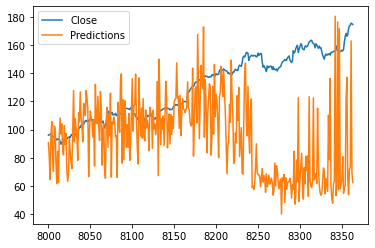

In [ ]:
plt.plot(valid_data[['Close']], label="Close")
plt.plot(valid_data[["Predictions"]], label="Predictions")
plt.legend()

In [ ]:
# train_data=new_dataset[:987]
valid_data2=new_dataset[:7940]
valid_data2['Predictions']=predicted_while_train
# plt.plot(train_data["Close"])
valid_data2['Predictions']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0         0.230510
1         0.230510
2         0.230510
3         0.230510
4         0.230510
           ...    
7935    100.390495
7936     78.333076
7937     71.290108
7938    108.483063
7939     86.576889
Name: Predictions, Length: 7940, dtype: float32

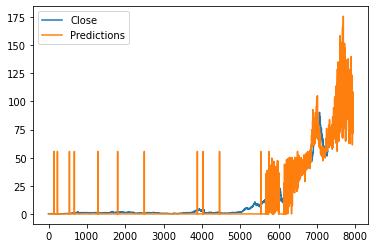

In [ ]:
plt.plot(valid_data2[['Close']], label="Close")
plt.plot(valid_data2[["Predictions"]], label="Predictions")
plt.legend()

In [ ]:
# train_data=new_dataset[:987]
valid_data2=new_dataset[5000:7940]
valid_data2['Predictions']=predicted_while_train[5000:]
# plt.plot(train_data["Close"])
valid_data2['Predictions']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


5000      0.230510
5001      0.230510
5002      0.230510
5003      0.230510
5004      0.230510
           ...    
7935    100.390495
7936     78.333076
7937     71.290108
7938    108.483063
7939     86.576889
Name: Predictions, Length: 2940, dtype: float32

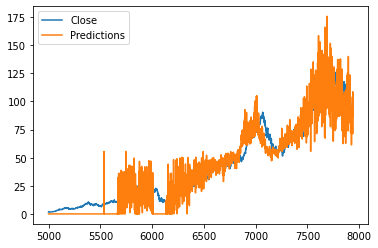

In [ ]:
plt.plot(valid_data2[['Close']], label="Close")
plt.plot(valid_data2[["Predictions"]], label="Predictions")
plt.legend()

In [ ]:
# train_data=new_dataset[:987]
valid_data2=new_dataset[6000:7000]
valid_data2['Predictions']=predicted_while_train[6000:7000]
# plt.plot(train_data["Close"])
valid_data2['Predictions']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


6000    27.703629
6001    19.192596
6002     0.230510
6003     0.230510
6004    27.462011
          ...    
6995    76.590096
6996    77.088783
6997    79.172401
6998    72.332413
6999    88.204689
Name: Predictions, Length: 1000, dtype: float32

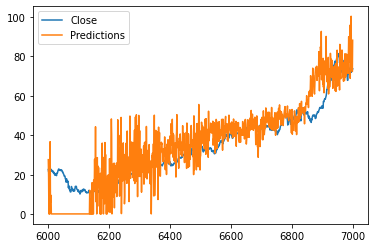

In [ ]:
plt.plot(valid_data2[['Close']], label="Close")
plt.plot(valid_data2[["Predictions"]], label="Predictions")
plt.legend()

In [ ]:
# train_data=new_dataset[:987]
valid_data2=new_dataset[7500:7940]
valid_data2['Predictions']=predicted_while_train[7500:]
# plt.plot(train_data["Close"])
valid_data2['Predictions']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


7500     89.412460
7501     97.080994
7502     93.472031
7503     84.500870
7504     91.917068
           ...    
7935    100.390495
7936     78.333076
7937     71.290108
7938    108.483063
7939     86.576889
Name: Predictions, Length: 440, dtype: float32

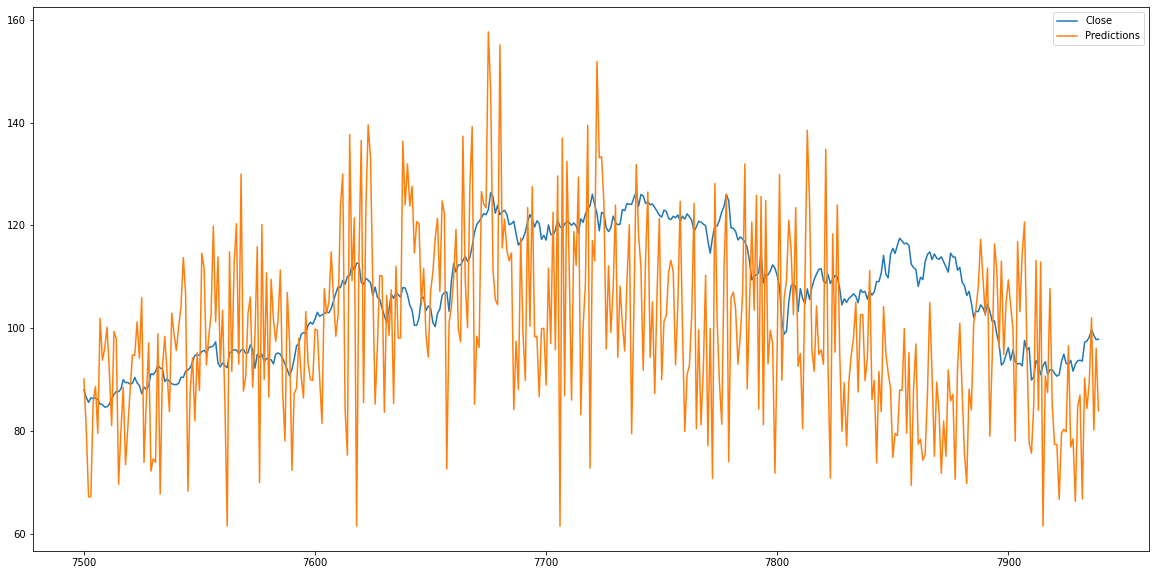

In [ ]:
plt.plot(valid_data2[['Close']], label="Close")
plt.plot(valid_data2[["Predictions"]], label="Predictions")
plt.legend()